## Ice Temperature (icetemp) Package Tutorial

In [1]:
# Standard imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Imports from ice temperature estimation package
import icetemp
import icetemp.data_io as io
import icetemp.model as m

This package is intended to infer the change in temperature from measurements of temperature ($^\circ$C) and depth (m) off of thermistor provided by the AMANDA and IceCube collaborations. Our baseline hypothesis determines a quadratic relationship between the ice temperature and depth, but we will also consider a linear dependence. 

We have contructed a generative model to analyze the data which involves uniform priors for each term of the polinomials studied and a normal likelihood to relate the Gaussian uncertainties in one dimension. These uncertaintes or noise sources are considered directly related to the thermistor technical information. 
___
In the case of the straight line fit, we have $ T = f(d) = m \cdot d + b$ where d is the depth and T is the temperature. For each of the true T values with Gaussian uncertainties, we get that the frequency distribution $p(T_i|d_i,\sigma_{Ti},m,b)$ for $T_i$ is $$ p(T_i|d_i,\sigma_{Ti},m,b) = \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(T_i - md_i - b)^2}{2\sigma_T^2}\Big).$$

We have no prior information about the dependence of temperature over depth, and for that reason we shall considera "Flat" prior for our parameters. Regarding the intecept we could assume it will be in the expected temperature, at ground level, in the Antarctic, which ranges from -20°C (summer) to -60°C (winter).  We can then define our statistical model as:
$$ m \sim \text{Uniform}( m^l, m^u) \rightarrow m \sim \text{Uniform}(-\infty ,\infty)$$

$$ b \sim \text{Uniform}( b^l, b^u) \rightarrow b \sim \text{Uniform}(-\infty ,\infty)$$ where we define $\mu_i = m \cdot d_i + b$

$$ T_i \sim \text{Normal}(\mu_i,\sigma_\text{T})$$

The likelihood of the parameter is given by: 
$$ \mathcal{L} \propto \prod_i \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(y_i - mx_i - b)^2}{2\sigma_T^2}\Big) $$
___
In the case of the quadratic line fit, we have $ T = f(d) = q \cdot d^2 + m \cdot d + b$ where d is the depth and T is the temperature. For each of the true T values with Gaussian uncertainties, we get that the frequency distribution $p(T_i|d_i,\sigma_{Ti},m,b)$ for $T_i$ is $$ p(T_i|d_i,\sigma_{Ti},m,b) = \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(T_i - q d_i^2 - md_i - b)^2}{2\sigma_T^2}\Big).$$

We have no prior information about the dependence of temperature over depth, and for that reason we shall considera "Flat" prior for our parameters. Regarding the intecept we could assume it will be in the expected temperature, at ground level, in the Antarctic, which ranges from -20°C (summer) to -60°C (winter).  We can then define our statistical model as:
$$ q \sim \text{Uniform}( q^l, q^u) \rightarrow q \sim \text{Uniform}(-\infty , \infty)$$

$$ m \sim \text{Uniform}( m^l, m^u) \rightarrow m \sim \text{Uniform}(-\infty ,\infty)$$

$$ b \sim \text{Uniform}( b^l, b^u) \rightarrow b \sim \text{Uniform}(-\infty , \infty)$$ 

where we define $\mu_i = q \cdot d_i^2 + m \cdot d_i + b$

$$ T_i \sim \text{Normal}(\mu_i,\sigma_\text{T})$$

The likelihood of the parameter is given by: 
$$ \mathcal{L} \propto \prod_i \frac{1}{\sqrt{2\pi \sigma_T^2}} \exp \Big(\frac{-(y_i - q x_i^2 - mx_i - b)^2}{2\sigma_T^2}\Big) $$
___
___

#### Let's take a look at our data!

In [2]:
# load some (real) data
ex_data = io.load_ice_data("icecube_temp.2007.txt", data_year=2007,temp_errors=0.1, depth_errors=2)
print(ex_data)

    Temperature    Depth  data_year  temp_errors  depth_errors
0        -28.76 -2078.18       2007          0.1             2
1        -25.09 -2214.35       2007          0.1             2
2        -20.93 -2350.52       2007          0.1             2
3        -26.51 -2161.09       2007          0.1             2
4        -22.42 -2297.25       2007          0.1             2
5        -17.89 -2433.42       2007          0.1             2
6        -25.79 -2195.40       2007          0.1             2
7        -21.55 -2331.57       2007          0.1             2
8        -18.23 -2433.69       2007          0.1             2
9        -26.26 -2171.54       2007          0.1             2
10       -17.69 -2443.87       2007          0.1             2


Using our object (Pandas DataFrame) we can calculate the likelihood function of our statistical model. Below, the likelihood is calculated for some linear and quadratic test data. The details of how this test data was generated are provided in the `test_data` directory. 

The likelihood value for the linear model with the test data is 5350803797.71
The likelihood value for the quadrartc model with the test data is 21583804.54


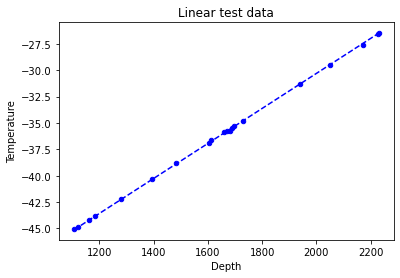

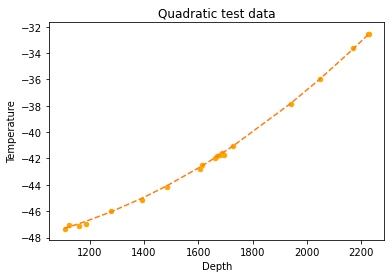

In [3]:
# defining model parameters for linear and quadratic fit (used to generate test data)
a0_lin, a1_lin = -6.35e1, 1.66e-2
a0_quad, a1_quad, a2_quad = -4.66e1, -7.47e-3, 6.18e-6

# linear test data
test_linear = io.load_ice_data("test_data_linear.txt", data_year=0, temp_errors=0.1, depth_errors=2, data_dir='test_data')
test_linear.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1, color='blue')
x = test_linear['Depth'].values
print('The likelihood value for the linear model with the test data is {:.2f}'.format(m.calc_linear_likelihood(test_linear, a1_lin, a0_lin)))
x.sort()
plt.plot(x, a1_lin*x + a0_lin, color='blue', linestyle='dashed')
plt.title("Linear test data")

# quadratic test data
test_quad = io.load_ice_data("test_data_quadratic.txt", data_year=0, temp_errors=0.1, depth_errors=2, data_dir='test_data')
test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
plt.plot(x, a2_quad*x**2 + a1_quad*x + a0_quad, linestyle='dashed')
plt.title("Quadratic test data")
print('The likelihood value for the quadrartc model with the test data is {:.2f}'.format(m.calc_quad_likelihood(test_quad, a2_quad, a1_quad, a0_quad)))

## Doing some inference on the test data

The function `fit_quad()` in `model.py` fits the data to a quadratic function and extracts the relevant parameters and covariance matrix. Let's do some inference on the quadratic test data and see if our parameters agree to a reasonable extent. For this leg of the project, only the errors on the temperature were considered.  

Values used to generate data:
a = -46.6
b = -0.00747
q = 6.18e-06

Best fit values:
a = -46.3 ± 0.479
b = -0.00791 ± 0.000592
q = 6.33e-06 ± 1.77e-07

Covariance Matrix:
 [[ 2.29767404e-01 -2.81805104e-04  8.27913796e-08]
 [-2.81805104e-04  3.50738482e-07 -1.04311555e-10]
 [ 8.27913796e-08 -1.04311555e-10  3.13874733e-14]]


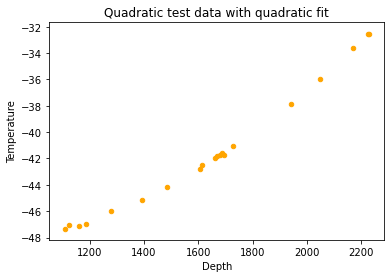

In [13]:
params, cov_mat = m.fit_quad(test_quad)

print("Values used to generate data:")
print("a = {:.3}".format(a0_quad))
print("b = {:.3}".format(a1_quad))
print("q = {:.3}".format(a2_quad))

# print formatting function adapted from HW 6 solutions
uncertainties = np.sqrt(np.diag(cov_mat))
print("\nBest fit values:")
for value, sigma, name in zip(params, uncertainties, 'abq'):
    print('{} = {:.3} ± {:.3}'.format(name, value, sigma))

    
test_quad.plot(x='Depth', y='Temperature', kind='scatter', yerr=0.1,color='orange')
plt.title("Quadratic test data with quadratic fit")

Indeed, this simple inference returns the parameters with which we generated the data within the errors.